# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt
from imageio import imread
from skimage import io, transform
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

# Batch size handled in class

batch_size = 30     #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
class data_generator():
    
    def __init__(self, img_idx =15, image_ht=100, image_wd=100, image_channel =3, factor_ht=0, factor_wd=0):
        self.img_idx = img_idx
        self.image_ht = image_ht
        self.image_wd = image_wd
        self.factor_ht = factor_ht
        self.factor_wd = factor_wd
        self.image_channel = image_channel
        
        if factor_ht!=0 or factor_wd !=0:
            self.crop=True
        else:
            self.crop=False
    
    
    def input_shape(self):
        if self.crop:
            ht = self.image_ht - self.factor_ht # in case cropping need to be done, we need to readjust height of images
            wd = self.image_wd - self.factor_wd # in case cropping need to be done, we need to readjust width of images
        else:
            ht=self.image_ht
            wd=self.image_wd
            
        return (self.img_idx, ht, wd, self.image_channel)
    
#     def crop_n_resize(self,image):
        
#         # Resize
#         resized = resize(image, (self.image_ht,self.image_wd, self.image_channel))
        
#         # Crop
#         ht1 = int(self.factor_ht / 2)
#         ht2 = self.image_ht - int(self.factor_ht /2)
#         wd1 = int(self.factor_wd / 2)
#         wd2 = self.image_wd - int(self.factor_wd / 2)
        
#         image=resized[ht1:ht2, wd1:wd2,:]
#         return image
        
        
        
    def batch_data(self, batch, t, source_path):
        
        if self.crop:
            ht = self.image_ht - self.factor_ht # in case cropping need to be done, we need to readjust height of images
            wd = self.image_wd - self.factor_wd # in case cropping need to be done, we need to readjust width of images
        else:
            ht=self.image_ht
            wd=self.image_wd
            
            
        if self.remaining==0:
            sequence=self.batch_size
        else:
            sequence=self.remaining
        
        batch_data = np.zeros((sequence, self.img_idx , ht ,wd ,self.image_channel)) 
        # x is the number of images you use for each video, (y,z) is the final size of the input images 
        # and 3 is the number of channels RGB
        
        batch_labels = np.zeros((sequence,5)) # batch_labels is the one hot representation of the output
        img_idx=range(0,30,30 // self.img_idx)
        
        for folder in range(sequence): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + 
                                                 (batch* self.batch_size)].split(';')[0]) # read all the images in the folder
            
            for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch* self.batch_size)].strip().split(';')[0]+
                               '/'+imgs[item]).astype(np.float32)

                # Resize
                image = resize(image, (self.image_ht,self.image_wd, self.image_channel))

                # Crop
                if self.crop:
                    ht1 = int(self.factor_ht / 2)
                    ht2 = self.image_ht - int(self.factor_ht /2)
                    wd1 = int(self.factor_wd / 2)
                    wd2 = self.image_wd - int(self.factor_wd / 2)
                    image=image[ht1:ht2, wd1:wd2,:]

                batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        return batch_data, batch_labels
    
    
    def generator(self, source_path, folder_list, batch_size):
        self.batch_size= batch_size
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        img_idx = range(self.img_idx) #create a list of image numbers you want to use for a particular video
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size # calculate the number of batches
            self.remaining=0
            for batch in range(num_batches): # we iterate over the number of batches
                
                batch_data, batch_labels = self.batch_data(batch, t, source_path)

                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            else:
                self.remaining= len(t) % self.batch_size
                if (self.remaining != 0):
                    batch_data, batch_labels = self.batch_data(num_batches, t, source_path)
                    yield batch_data, batch_labels



### Testing Generator Class

Source path =  Project_data/train ; batch size = 32


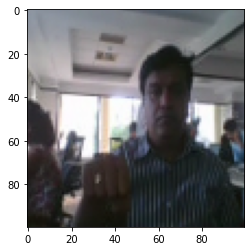

In [5]:
# Test Generator Function
data= data_generator()
xtrain=data.generator('Project_data/train',train_doc, 32 )
x=next(xtrain)
plt.imshow(x[0][1][1])

Source path =  Project_data/train ; batch size = 32


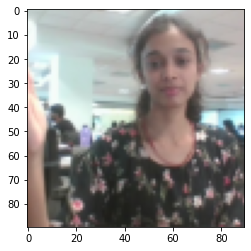

In [6]:
# Test Crop in Generator Function
data= data_generator(factor_ht=10, factor_wd=10)
xtrain=data.generator('Project_data/train',train_doc, 32 )
x=next(xtrain)
plt.imshow(x[0][1][1])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# num_epochs = # choose the number of epochs
# print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.applications import EfficientNetB0
#write your model here
from tensorflow.keras import optimizers
from keras.layers import LeakyReLU

In [10]:
class model_execution(data_generator):
    
    def __init__(self, img_idx =30, image_ht=100, image_wd=100, image_channel =3, factor_ht=0, factor_wd=0):
        super().__init__(img_idx,image_ht, image_wd, image_channel, factor_ht,factor_wd )
        
        
    def compile_and_summary(self,model):
        optimiser = Adam(learning_rate=0.001) #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print(model.summary())
        self.model=model
    
    def run_model(self, batch_size = 30, epoch_num=1):
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = self.generator(train_path, train_doc, batch_size)
        val_generator = self.generator(val_path, val_doc, batch_size)
        
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5) # write the REducelronplateau code here
        EarlyStop= EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
        callbacks_list = [checkpoint, LR, EarlyStop]
        
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
       
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, 
        # you'll be able to save the model at the end of each epoch.
        self.history = self.model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch_num, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
#         epoch_num=callback.stopped_epoch
#         self.callbacks_list = callbacks_list
        self.loss(len(self.history.history['loss']))
    
    def loss(self,epochs):
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

#### Define Class object and initialize parameters along with shape

In [11]:
executor = model_execution()

In [12]:
shape = executor.input_shape()
shape

(30, 100, 100, 3)

### Model 1 - Conv3d

In [22]:
# Define Model

conv3d_1 = Sequential()

conv3d_1.add(Conv3D(32,(2,2,2), activation='elu',  padding='same', input_shape= shape ))
conv3d_1.add(Conv3D(32,(2,2,2),  activation='elu'))
conv3d_1.add(BatchNormalization())
conv3d_1.add(Dropout(0.5))
conv3d_1.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_1.add(Conv3D(64,(2,2,2),padding='same', activation='elu'))
conv3d_1.add(Conv3D(64,(2,2,2),  activation='elu'))
conv3d_1.add(BatchNormalization())
conv3d_1.add(Dropout(0.5))
conv3d_1.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_1.add(Conv3D(64,(2,2,2), padding='same', activation='elu'))
conv3d_1.add(Conv3D(64,(2,2,2),  activation='elu'))
conv3d_1.add(BatchNormalization())
conv3d_1.add(Dropout(0.5))
conv3d_1.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_1.add(Flatten())
conv3d_1.add(Dense(64, activation='relu'))
conv3d_1.add(BatchNormalization())

conv3d_1.add(Dense(5, activation='softmax'))

In [23]:
# Create Object
executor1 = model_execution()

# Compile Model

executor1.compile_and_summary(conv3d_1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 30, 100, 100, 32)  800       
                                                                 
 conv3d_19 (Conv3D)          (None, 29, 99, 99, 32)    8224      
                                                                 
 batch_normalization_9 (Batc  (None, 29, 99, 99, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 29, 99, 99, 32)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 14, 49, 49, 32)   0         
 3D)                                                             
                                                                 
 conv3d_20 (Conv3D)          (None, 14, 49, 49, 64)   

Source path =  Project_data/train ; batch size = 30
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.1493 - categorical_accuracy: 0.5716 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-0819_58_54.535217\model-00001-1.14934-0.57164-3.48694-0.19000.h5
23/23 [==============================] - 790s 34s/step - loss: 1.1493 - categorical_accuracy: 0.5716 - val_loss: 3.4869 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.4694 - categorical_accuracy: 0.8522 
Epoch 2: saving model to model_init_2022-04-0819_58_54.535217\model-00002-0.46939-0.85219-6.76719-0.16000.h5
23/23 [==============================] - 768s 33s/step - loss: 0.4694 - categorical_accuracy: 0.8522 - val_loss: 6.7672 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.3796 - categorical_accuracy: 0.8793    
Epoch 3: saving model t

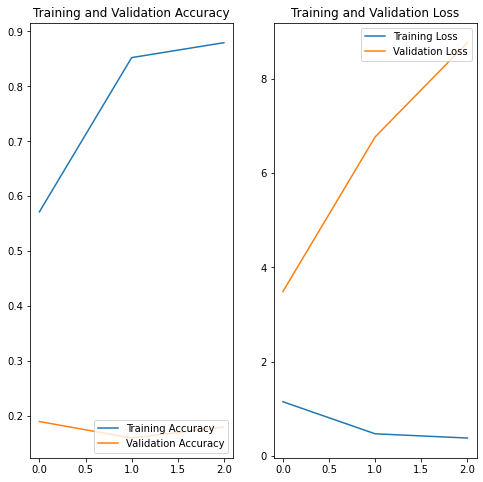

In [24]:
# Run the model

executor1.run_model(30, 3)

Source path =  Project_data/train ; batch size = 30
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 6.6050 - categorical_accuracy: 0.3062 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-0819_58_54.535217\model-00001-6.60502-0.30618-12.41803-0.18000.h5
23/23 [==============================] - 814s 36s/step - loss: 6.6050 - categorical_accuracy: 0.3062 - val_loss: 12.4180 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 2.5992 - categorical_accuracy: 0.4510 
Epoch 2: saving model to model_init_2022-04-0819_58_54.535217\model-00002-2.59917-0.45098-5.38880-0.19000.h5
23/23 [==============================] - 820s 36s/step - loss: 2.5992 - categorical_accuracy: 0.4510 - val_loss: 5.3888 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.9654 - categorical_accuracy: 0.5445 
Epoch 3: saving model to

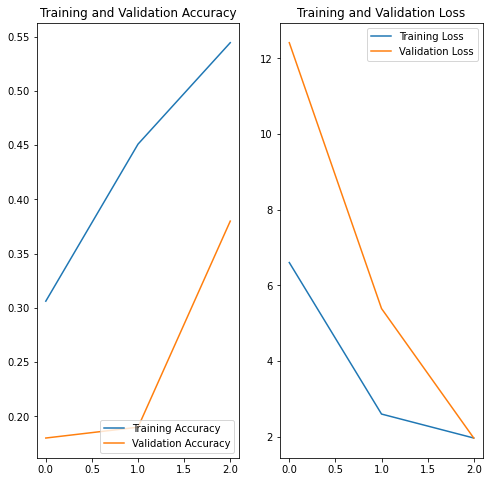

In [18]:
# Run the model

executor1.run_model(30, 3)

In [67]:
# Run the model

executor1.run_model(30, 20)

Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 7.9927 - categorical_accuracy: 0.3590 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-0718_55_41.129213\model-00001-7.99272-0.35897-1.96744-0.17000.h5
23/23 [==============================] - 305s 13s/step - loss: 7.9927 - categorical_accuracy: 0.3590 - val_loss: 1.9674 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6231 - categorical_accuracy: 0.6109 
Epoch 2: saving model to model_init_2022-04-0718_55_41.129213\model-00002-1.62306-0.61086-4.22956-0.15000.h5
23/23 [==============================] - 344s 15s/step - loss: 1.6231 - categorical_accuracy: 0.6109 - val_loss: 4.2296 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.6426 - categorical_accuracy: 0.7843 
Epoch 3: saving model t

NameError: name 'callback' is not defined

## Model 1A - Adding more dropout layers

In [101]:
# Define Model

conv3d_1a = Sequential()

conv3d_1a.add(Conv3D(32,(2,2,2), activation='relu',  padding='same', input_shape= shape ))
conv3d_1a.add(Dropout(0.25))
conv3d_1a.add(Conv3D(32,(2,2,2),  activation='relu'))
conv3d_1a.add(Dropout(0.5))
conv3d_1a.add(BatchNormalization())
conv3d_1a.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_1a.add(Conv3D(64,(2,2,2),padding='same', activation='relu'))
conv3d_1a.add(Dropout(0.25))
conv3d_1a.add(Conv3D(64,(2,2,2),  activation='relu'))
conv3d_1a.add(Dropout(0.5))
conv3d_1a.add(BatchNormalization())
conv3d_1a.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_1a.add(Conv3D(128,(2,2,2),padding='same', activation='relu'))
conv3d_1a.add(Dropout(0.25))
conv3d_1a.add(Conv3D(128,(2,2,2),  activation='relu'))
conv3d_1a.add(Dropout(0.5))
conv3d_1a.add(BatchNormalization())
conv3d_1a.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_1a.add(Flatten())


conv3d_1a.add(Dense(5, activation='softmax'))

In [102]:
# Create Object
executor1a = model_execution()

# Compile Model

executor1a.compile_and_summary(conv3d_1a)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_90 (Conv3D)          (None, 30, 100, 100, 32)  800       
                                                                 
 dropout_68 (Dropout)        (None, 30, 100, 100, 32)  0         
                                                                 
 conv3d_91 (Conv3D)          (None, 29, 99, 99, 32)    8224      
                                                                 
 dropout_69 (Dropout)        (None, 29, 99, 99, 32)    0         
                                                                 
 batch_normalization_56 (Bat  (None, 29, 99, 99, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_50 (MaxPoolin  (None, 14, 49, 49, 32)   0         
 g3D)                                                

Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 14.6362 - categorical_accuracy: 0.2926 Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-0721_47_55.740698\model-00001-14.63620-0.29261-2.05349-0.25000.h5
23/23 [==============================] - 803s 35s/step - loss: 14.6362 - categorical_accuracy: 0.2926 - val_loss: 2.0535 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 5.9158 - categorical_accuracy: 0.3831 
Epoch 2: saving model to model_init_2022-04-0721_47_55.740698\model-00002-5.91581-0.38311-5.38742-0.22000.h5
23/23 [==============================] - 794s 34s/step - loss: 5.9158 - categorical_accuracy: 0.3831 - val_loss: 5.3874 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 2.1906 - categorical_accuracy: 0.6214 
Epoch 3: saving mode

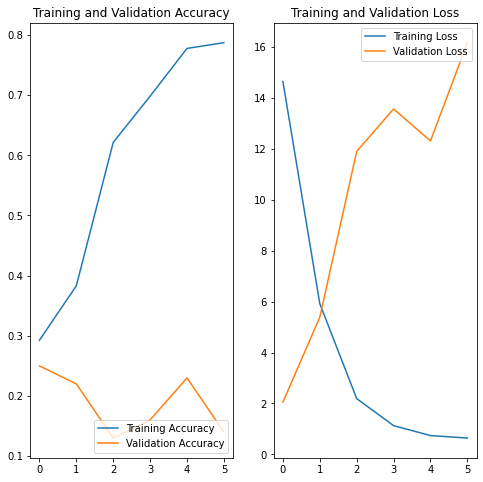

In [103]:
# Run the model

executor1a.run_model(30, 20)

### Model 2 - Conv3d with Dense Layers

In [301]:
# Define Model

conv3d_2 = Sequential()

conv3d_2.add(Conv3D(32,(2,2,2), activation='relu',
          input_shape= shape ))
conv3d_2.add(Dropout(0.25))
conv3d_2.add(Conv3D(32,(2,2,2),  activation='relu'))
conv3d_2.add(Dropout(0.5))
conv3d_2.add(BatchNormalization())
conv3d_2.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_2.add(Conv3D(64,(2,2,2), activation='relu'))
conv3d_2.add(Conv3D(64,(2,2,2),  activation='relu'))
conv3d_2.add(Dropout(0.5))
conv3d_2.add(BatchNormalization())
conv3d_2.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_2.add(Conv3D(128,(2,2,2), activation='relu'))
conv3d_2.add(Conv3D(128,(2,2,2),  activation='relu'))
conv3d_2.add(Dropout(0.5))
conv3d_2.add(BatchNormalization())
conv3d_2.add(MaxPooling3D(pool_size= (2,2,2)))

conv3d_2.add(Flatten())

conv3d_2.add(Dense(128, activation='relu'))
conv3d_2.add(Dense(64, activation='relu'))
conv3d_2.add(Dense(5, activation='softmax'))

In [82]:
# Create Object
executor2 = model_execution()

# Compile Model

executor2.compile_and_summary(conv3d_2)

NameError: name 'conv3d_2' is not defined

In [ ]:
# Run the model

executor2.run_model( 60, 20)

### Model 3 - Conv2d with LSTM Layers

In [29]:
# Define Model

conv2d_3 = Sequential()

conv2d_3.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'), input_shape=(shape)))
conv2d_3.add(TimeDistributed(Conv2D(64,(3,3),  activation='relu')))
conv2d_3.add(TimeDistributed(Dropout(0.5)))
conv2d_3.add(TimeDistributed(BatchNormalization()))
conv2d_3.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

conv2d_3.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
conv2d_3.add(TimeDistributed(Conv2D(64,(3,3),  activation='relu')))
conv2d_3.add(TimeDistributed(Dropout(0.5)))
conv2d_3.add(TimeDistributed(BatchNormalization()))
conv2d_3.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

conv2d_3.add(TimeDistributed(Flatten()))

conv2d_3.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
conv2d_3.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))

conv2d_3.add(Dense(5, activation='softmax'))


In [31]:
# Create Object
executor3 = model_execution()

# Compile Model

executor3.compile_and_summary(conv2d_3)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_72 (TimeDi  (None, 30, 98, 98, 64)   1792      
 stributed)                                                      
                                                                 
 time_distributed_73 (TimeDi  (None, 30, 96, 96, 64)   36928     
 stributed)                                                      
                                                                 
 time_distributed_74 (TimeDi  (None, 30, 96, 96, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_75 (TimeDi  (None, 30, 96, 96, 64)   256       
 stributed)                                                      
                                                                 
 time_distributed_76 (TimeDi  (None, 30, 48, 48, 64)  

In [ ]:
# Run the model

executor3.run_model( 60, 20)

### Model 4 - Conv2d with GRU Layers

In [33]:
# Define Model

conv2d_4 = Sequential()

conv2d_4.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'), input_shape=(shape)))
conv2d_4.add(TimeDistributed(Conv2D(64,(3,3),  activation='relu')))
conv2d_4.add(TimeDistributed(Dropout(0.5)))
conv2d_4.add(TimeDistributed(BatchNormalization()))
conv2d_4.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

conv2d_4.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
conv2d_4.add(TimeDistributed(Conv2D(64,(3,3),  activation='relu')))
conv2d_4.add(TimeDistributed(Dropout(0.5)))
conv2d_4.add(TimeDistributed(BatchNormalization()))
conv2d_4.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

conv2d_4.add(TimeDistributed(Flatten()))

conv2d_4.add(GRU(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))

conv2d_4.add(Dense(5, activation='softmax'))

In [35]:
# Create Object
executor4 = model_execution()

# Compile Model

executor4.compile_and_summary(conv2d_4)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_95 (TimeDi  (None, 30, 98, 98, 64)   1792      
 stributed)                                                      
                                                                 
 time_distributed_96 (TimeDi  (None, 30, 96, 96, 64)   36928     
 stributed)                                                      
                                                                 
 time_distributed_97 (TimeDi  (None, 30, 96, 96, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 30, 96, 96, 64)   256       
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 30, 48, 48, 64) 

In [ ]:
# Run the model

executor.run_model( 60, 20)

### Model 5 - Transfer Learning with GRU Layers

In [47]:
# Define Model

tran_model_5 = Sequential()
tran_model_5.add(TimeDistributed(EfficientNetB0(weights='imagenet', include_top=False),input_shape=shape))

for layer in tran_model_5.layers:
    layer.trainable = False

tran_model_5.add(TimeDistributed(Flatten()))    
tran_model_5.add(GRU(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
tran_model_5.add(Dense(5,activation='softmax'))

In [48]:
# Create Object
executor5 = model_execution()

# Compile Model

executor5.compile_and_summary(tran_model_5)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_113 (TimeD  (None, 30, 3, 3, 1280)   4049571   
 istributed)                                                     
                                                                 
 time_distributed_114 (TimeD  (None, 30, 11520)        0         
 istributed)                                                     
                                                                 
 gru_5 (GRU)                 (None, 30, 128)           4473600   
                                                                 
 dense_7 (Dense)             (None, 30, 5)             645       
                                                                 
Total params: 8,523,816
Trainable params: 4,474,245
Non-trainable params: 4,049,571
_________________________________________________________________
None


In [ ]:
# Run the model

executor.run_model( 60, 20)

In [108]:
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same',
         input_shape=shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5,activation='softmax'))

ValueError: Exception encountered when calling layer "max_pooling3d_61" (type MaxPooling3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling3d_61/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](Placeholder)' with input shapes: [?,1,6,6,128].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 6, 6, 128), dtype=float32)

In [106]:
chor=model_execution()
chor.compile_and_summary(model)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_96 (Conv3D)          (None, 30, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 30, 100, 100, 16)  0         
                                                                 
 batch_normalization_59 (Bat  (None, 30, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_53 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_97 (Conv3D)          (None, 15, 50, 50, 32)    13856     
                                                                 
 activation_13 (Activation)  (None, 15, 50, 50, 32)  

Source path =  Project_data/train ; batch size = 60
Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 2.4326 - categorical_accuracy: 0.1931 Source path =  Project_data/val ; batch size = 60

Epoch 1: saving model to model_init_2022-04-0721_47_55.740698\model-00001-2.43264-0.19306-1.98830-0.14000.h5
12/12 [==============================] - 271s 23s/step - loss: 2.4326 - categorical_accuracy: 0.1931 - val_loss: 1.9883 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 2.1836 - categorical_accuracy: 0.1765 
Epoch 2: saving model to model_init_2022-04-0721_47_55.740698\model-00002-2.18358-0.17647-2.09067-0.17000.h5
12/12 [==============================] - 265s 22s/step - loss: 2.1836 - categorical_accuracy: 0.1765 - val_loss: 2.0907 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 2.2275 - categorical_accuracy: 0.1965 
Epoch 3: saving model t

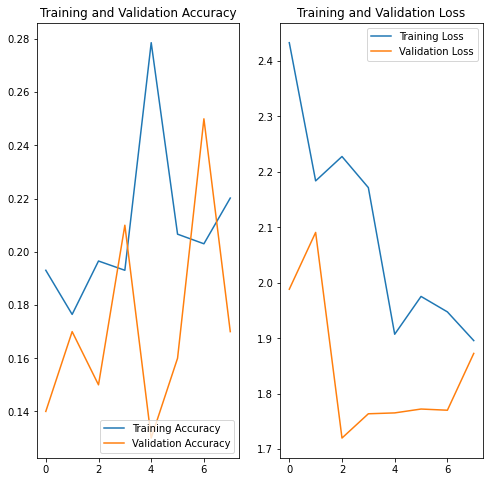

In [107]:
chor.run_model( 60, 20)

In [112]:
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same',
         input_shape=shape))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Conv3D(32, (3,3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5,activation='softmax'))

In [113]:
chor_modified=model_execution()
chor_modified.compile_and_summary(model)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_114 (Conv3D)         (None, 30, 100, 100, 32)  2624      
                                                                 
 activation_30 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 batch_normalization_79 (Bat  (None, 30, 100, 100, 32)  128      
 chNormalization)                                                
                                                                 
 conv3d_115 (Conv3D)         (None, 28, 98, 98, 32)    27680     
                                                                 
 activation_31 (Activation)  (None, 28, 98, 98, 32)    0         
                                                                 
 batch_normalization_80 (Bat  (None, 28, 98, 98, 32)   128       
 chNormalization)                                    

In [ ]:
chor_modified.run_model( 60, 20)

Source path =  Project_data/train ; batch size = 60
Epoch 1/20
